In [36]:
import pandas as pd
import os
from progressbar import ProgressBar
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob, Word

In [37]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

In [38]:
stopwords = set(STOPWORDS)
from spacy.lang.en.stop_words import STOP_WORDS

In [39]:
def getData(file):
    data = pd.read_csv("../data/extracted/"+file,delimiter=',')
    moviename = ' '.join(file[:-4].split('_'))
    return data, moviename

In [40]:
def convertToModelInputFormat(data):
    ans = []
    speakers = list(set(list(data['Speaker'])))
    for speaker in speakers:
        dialogues = data[data['Speaker']==speaker]
        dialogues = list(dialogues['Dialogue'])
        temp = []
        temp.append(speaker)
        temp.append(dialogues)
        ans.append(temp)
    return ans

In [41]:
def getTrueLabels(df, moviename):
    labelsfile = pd.read_csv('../data/Pre-processing_files/polygraph_matched_scriptid_title_gender.txt', 
                         delimiter='\t', names=['Match', 'Movie', 'Code', 'Character', 'Gender'])
    labelsfile = labelsfile[labelsfile['Match']=='Matched']

    movie = labelsfile[labelsfile['Movie']==moviename]
    if movie is not None:
        movie = movie[['Character', 'Gender']]
        movie['Character'] = movie['Character']
        temp = list(df['Speaker'])
        gen = []
#         print(temp, movie['Character'])
        count = 0
        for speaker in temp:
            try:
                gender = movie[movie['Character'].str.contains(speaker)]
                gender = list(gender['Gender'])
                gen.append(gender[0])
            except:
                gen.append(np.nan)
        df['Gender'] = gen
    return df

In [42]:
entire_data = pd.DataFrame([['Speaker', ['d1']]], columns=['Speaker', 'Dialogues'])
files = os.listdir('../data/extracted')
files.sort()
pbar = ProgressBar()
for file in pbar(files):
    if file[-4:] != ".csv":
        continue
    else:
        data, moviename = getData(file)
        ans = convertToModelInputFormat(data)
        df = pd.DataFrame(ans, columns = ['Speaker', 'Dialogues'])
        df = getTrueLabels(df, moviename)
        df['Movie'] = moviename
        entire_data = entire_data.append(df, ignore_index=True)

entire_data = entire_data.drop(0)
entire_data.head()

100% |########################################################################|


,Speaker,Dialogues,Gender,Movie
1,patrick,"[I missed you., It was a bratwurst. I was eat...",m,10 Things I Hate About You
2,bogey,"[Nice to see you. Martini bar to the right, s...",NaN,10 Things I Hate About You
3,michael,"[You the new guy?, C'mon. I'm supposed to giv...",m,10 Things I Hate About You
4,pepe,"[Some people like the Colombian, but it all de...",NaN,10 Things I Hate About You
5,cameron,"[I don't think so, ma'am, So they tell me..., ...",m,10 Things I Hate About You


In [43]:
entire_data.shape

(42843, 4)

In [58]:
def getRightFormat(entire_data):
    new_data = entire_data[['Speaker', 'Dialogues', 'Gender']]
    dialogues = new_data['Dialogues'].tolist()
    
    new_d = [ ' '.join(dial) for dial in dialogues]
    
    new_data['Dialogues'] = new_d
    df = new_data.groupby('Gender')['Dialogues'].apply(' '.join).reset_index()    
    df = df.set_index('Gender')
    return df

In [59]:
wc_data = getRightFormat(entire_data)
# male = entire_data[entire_data['Gender'] == 'm']
# male.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [73]:
wc_data.head()
# female = entire_data[entire_data['Gender'] == 'f']
# female.shape

,Dialogues
Gender,
?,"Where'd you get all this Nazi stuff? Boss, Osw..."
f,Did you change your hair? You might wanna thin...
m,I missed you. It was a bratwurst. I was eatin...


In [81]:
def vectorise(words):
    speakers = df.Gender.unique()
    corpus = [' '.join(df[(df.Gender==candidate)]['Dialogues'].tolist()) for candidate in speakers]
    cv=CountVectorizer( stop_words=STOP_WORDS, ngram_range=(1, 3))
    X = cv.fit_transform(corpus)
    X = X.toarray()
    bow=pd.DataFrame(X, columns = cv.get_feature_names())
    bow.index=speakers
    return bow, speakers

In [95]:
bow, genders = vectorise(wc_data)

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [96]:
bow.head()

,00,00 01,00 01 happens,00 03,00 03 21,00 03 22,00 afternoon,00 afternoon dawson,00 bob,00 bob kahan,...,zzz buddy,zzz buddy ll,zzz thing,zzz thing know,zzzzzz,zzzzzz stares,zzzzzz stares wow,zzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzz thing,zzzzzzzzzzzzzzzz thing chipping
?,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f,10,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
m,33,0,0,2,1,1,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1


In [77]:
def getWordCloud(bow, col):
    text=bow.loc[col].sort_values(ascending=False)[:4000]

    # create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
    text2_dict=bow.loc[col].sort_values(ascending=False).to_dict()

    # create the WordCloud object
    wordcloud = WordCloud(min_word_length =3,
                          background_color='white')

    # generate the word cloud
    wordcloud.generate_from_frequencies(text2_dict)

    #plot
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

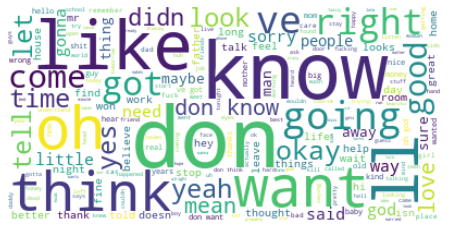

In [78]:
getWordCloud(bow, 'f')

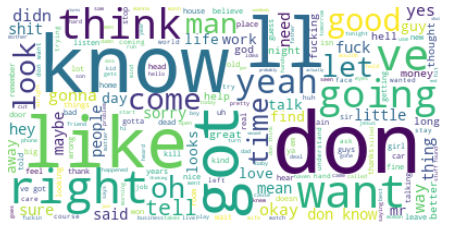

In [79]:
getWordCloud(bow, 'm')

In [80]:
import math

In [97]:
def logOdds(speakers, bow):
    t_bow_df=pd.DataFrame()
    bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1)
    pbar = ProgressBar()
    for candidate in pbar(speakers):
        feat_s = bow[bow.index != candidate].sum()+1 #sum all the times each word was said excluding the candidate
        feat_s_all = np.sum(bow[bow.index != candidate].sum()) # all the total words that were said, excluding the candidate
        tot = feat_s / feat_s_all #find the frequency of words said among other candidates
        row = bow_transformed.loc[candidate] / tot #divide the candidate's array of frequency of words by all other candidates' frequency
        row = pd.DataFrame(row).T #create a df, and transform
        results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency

        t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[candidate])]) #append to df
    return t_bow_df

In [98]:
bow_df = logOdds(['f', 'm'], bow)

100% |########################################################################|


In [99]:
bow_df.head()

,00,00 01,00 01 happens,00 03,00 03 21,00 03 22,00 afternoon,00 afternoon dawson,00 bob,00 bob kahan,...,zzz buddy,zzz buddy ll,zzz thing,zzz thing know,zzzzzz,zzzzzz stares,zzzzzz stares wow,zzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzz thing,zzzzzzzzzzzzzzzz thing chipping
f,-0.340922,2.287109,2.287109,-0.297853,0.287109,0.287109,2.287109,2.287109,0.287109,0.287109,...,0.287109,0.287109,0.287109,0.287109,0.287109,0.287109,0.287109,0.287109,0.287109,0.287109
m,0.341516,-2.286515,-2.286515,0.298448,-0.286515,-0.286515,-2.286515,-2.286515,-0.286515,-0.286515,...,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515,-0.286515


In [101]:
bow_df.loc['f'].sort_values(ascending=False)[:10]

mary clarence        6.872072
rmph                 6.746541
rm                   6.572511
rmph rm              6.145090
rapunzel             5.810671
dr lecter            5.609037
sound roll           5.535037
sound roll camera    5.535037
roll sound roll      5.535037
mr jimmy             5.457034
Name: f, dtype: float64

In [102]:
bow_df.loc['m'].sort_values(ascending=False)[:10]

rickey       4.942304
haul         4.922939
dignan       4.842768
missiles     4.520840
fait         4.468373
doolittle    4.357341
neckbone     4.237047
artagnan     4.205338
gallo        4.172917
bernstein    4.035413
Name: m, dtype: float64

In [103]:
def getCloud(bow_df, col):
    text = bow_df.loc[col].sort_values(ascending=False)[:4000]
    text3_dict={k: v for k, v in sorted(text.items(),reverse=True, key=lambda item: item[1])}
    wordcloud = WordCloud(min_word_length =3,
                      background_color='white').generate_from_frequencies(text3_dict)

    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

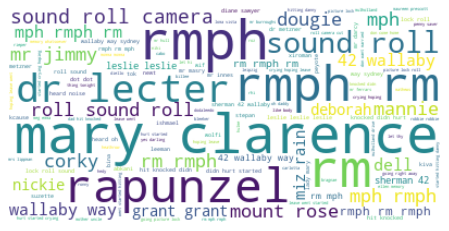

In [104]:
getCloud(bow_df, 'f')

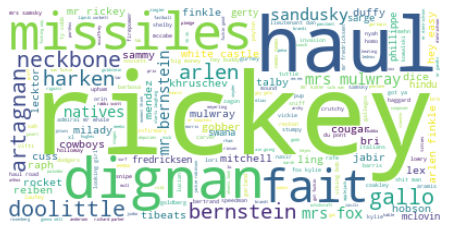

In [105]:
getCloud(bow_df, 'm')